# Import CLEMnet predictions
---
**Author**: Arent Kievits

**Date**: 25 July 2022

#### Overview
Quickly imports CLEMnet fluorescence predictions to `render-ws`.

As CLEMnet predicts fluorescence on CATMAID pngs, this assumes data is stored as

Stack | Filepath
- | -
stack_name | `/{project}/{stack_name}/{section}/{row}_{col}_{zoom}.png`

The code then outputs a `.tiff` of the full section and stack to be exported again for CATMAID

Stack | Filepath
- | -
stack_name | `/.../{project}/{stack_name}/{sectionId}/prediction.tif`

**Warning**:
Check filepath tree carefully before executing.

In [1]:
from pathlib import Path
import re
import shutil
from ruamel.yaml import YAML
import os

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
from tifffile import TiffFile, TiffWriter
import imageio as iio
import matplotlib.pyplot as plt

import renderapi
import icatapi
import fastemworkflow
from renderapi.transform import AffineModel

In [2]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 160)

#### Connect to `render-ws`

In [3]:
# render parameters
owner = 'akievits'
project = 'prototype_rat_pancreas'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'akievits',
 'project': 'prototype_rat_pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Import and export directories

In [4]:
# Import from
dir_project = Path(f'/long_term_storage/{owner}/FAST-EM/{project}')
dir_predictions = Path(f'/long_term_storage/{owner}/FAST-EM/{project}/hoechst_prediction')

# Stack directory
!ls -l $dir_predictions

total 4
drwxr-xr-x 2 akievits akievits 4096 Jul 25 15:05 0


In [5]:
# Find section directories
dir_sections = sorted([dir_ for dir_ in dir_predictions.iterdir() if dir_.is_dir()])
d_sections = {i: f'S00{d.name}' for i, d in enumerate(dir_sections)}

## 1) Create tile specifications
---

In [6]:
# Collect tile specifications
tile_dicts = []

# Loop through section directories
for z, sectionId in tqdm(d_sections.items()):

    # Loop through mipmap directories within each section
    dir_section = dir_predictions / str(z)
    for png in tqdm(list(dir_section.glob('*_*_0.png')),
                           leave=False):
        # Read png
        fp = dir_section / png
        # Infer row, col
        row, col = [int(i) for i in re.findall(r'\d+', fp.name)[:2]]
        # Build up tile specification
        ts = {}
        ts['imageUrl'] = f"https://sonic.tnw.tudelft.nl{fp.as_posix()}"
        ts['stack'] = dir_predictions.name
        ts['sectionId'] = sectionId
        ts['z'] = z
        ts['tileId'] = f'S{z:03d}-{row:03d}x{col:03d}'
        ts['width'] = 1024 # Standard
        ts['height'] = 1024 
        ts['imageRow'] = row
        ts['imageCol'] = col
        tile_dicts.append(ts)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

#### Create stack DataFrames

In [7]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)

# 'Normalize' row and column numbers
min_row = df_stacks['imageRow'].min()
min_col = df_stacks['imageCol'].min()
df_stacks['imageRow'] = df_stacks['imageRow'] - min_row
df_stacks['imageCol'] = df_stacks['imageCol'] - min_col

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

imageUrl  \
stack                                                                                                                                            
hoechst_prediction 10   https://sonic.tnw.tudelft.nl/long_term_storage/akievits/FAST-EM/prototype_rat_pancreas/hoechst_prediction/0/18_9_0.png   
                   55  https://sonic.tnw.tudelft.nl/long_term_storage/akievits/FAST-EM/prototype_rat_pancreas/hoechst_prediction/0/23_10_0.png   
                   62   https://sonic.tnw.tudelft.nl/long_term_storage/akievits/FAST-EM/prototype_rat_pancreas/hoechst_prediction/0/23_6_0.png   

                                    stack sectionId  z        tileId  width  \
stack                                                                         
hoechst_prediction 10  hoechst_prediction      S000  0  S000-018x009   1024   
                   55  hoechst_prediction      S000  0  S000-023x010   1024   
                   62  hoechst_prediction      S000  0  S000-023x006   1024   

                       height  imageRow  imageCol  
stack                                              
hoechst_prediction 10    1024         0         5  
                   55    1024         5         6  
                   62    1024         5         2

## 2) Output `predictions.tiff`

In [8]:
import imageio as io
from skimage import transform
import math

In [9]:
nrows = df_stacks['imageRow'].unique().size
ncols = df_stacks['imageCol'].unique().size
z_values = df_stacks['z'].unique().tolist()

# Loop through sections
for z, tileset in tqdm(df_stacks.groupby('z'),
                       total=len(z_values),
                       leave=False):
    
    # Intialize array for big tiff
    predictions = np.zeros((1024*nrows, 1024*ncols))
    
    # Loop through tiles
    for i, tile in tqdm(tileset.iterrows(), total=len(tileset)):
        
        # Fill array with values from image
        image = io.v2.imread(tile['imageUrl'].split('.nl')[1])
        row_id = tile['imageRow']*ts['height']
        col_id = tile['imageCol']*ts['width']
        predictions[row_id:(row_id+1024),col_id:(col_id+1024)] = image
    
    # Create output directory
    dir_out = dir_project / f"{tile['stack']}_tif" / tile['sectionId']
    dir_out.mkdir(parents=True, exist_ok=True)
    
    # Downsample to 160 nm/pixel
    predictions = predictions.astype('uint16')
    # height, width = predictions.shape
    # predictions_resize = transform.resize(predictions, output_shape=(math.ceil(height/40), math.ceil(width/40)))
    
    # Write big tiff
    fp_tif = dir_out / f"{tile['z']}.tif"
    with TiffWriter(fp_tif.as_posix()) as tif:
            tif.write(predictions)   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [10]:
dir_out

PosixPath('/long_term_storage/akievits/FAST-EM/prototype_rat_pancreas/hoechst_prediction_tif/S000')

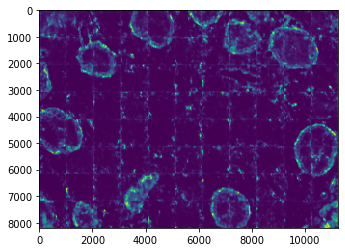

In [11]:
plt.imshow(predictions) # May take a while to plot depending on dimensions

In [12]:
# plt.imshow(predictions_resize) # May take a while to plot depending on dimensions

## 3) Create specifications for `render-ws` stack
---

In [18]:
# Find section directories
output_dir = dir_out.parent
dir_sections = sorted([dir_ for dir_ in output_dir.iterdir() if dir_.is_dir()])
d_sections = {i: d.name for i, d in enumerate(dir_sections)}

# Collect tile specifications
tile_dicts = []

# Loop through section directories
for z, sectionId in tqdm(d_sections.items()):

    # Loop through mipmap directories within each section
    dir_section = output_dir / str(sectionId)
    for file in tqdm(list(dir_section.glob('*.tif')),
                           leave=False):
        # tif
        fp = dir_section / file
        tiff = TiffFile(fp)
        image = tiff.asarray()
        shape = image.shape
        
        # Build up tile specification
        ts = {}
        ts['imageUrl'] = f"https://sonic.tnw.tudelft.nl{fp.as_posix()}"
        ts['stack'] = f'{dir_predictions.name}_tif'
        ts['sectionId'] = sectionId
        ts['z'] = z
        ts['tileId'] = f'S{z:03d}-{row:03d}x{col:03d}'
        ts['width'] = shape[1]
        ts['height'] = shape[0] 
        ts['minint'] = 0
        ts['maxint'] = 256
        ts['imageRow'] = 0
        ts['imageCol'] = 0
        ts['tforms'] = [AffineModel(B0=min_col*1024, B1=min_row*1024)]
        tile_dicts.append(ts)
        
        # TODO
        # Currently, the translation of the stack has to be set manually in CATMAID (Tx = min_col * tile_size * stack_resolution, Ty = min_row * tile_size * stack_resolution)
        # Find a way to set `tforms` automatically...

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# Create DataFrame from list of tile specifications
df_predictions = pd.DataFrame(tile_dicts)

# Sneak peak
df_predictions.groupby('stack')\
         .apply(lambda x: x.sample(1))

,imageUrl,stack,sectionId,z,tileId,width,height,minint,maxint,imageRow,imageCol,tforms
0,https://sonic.tnw.tudelft.nl/long_term_storage/akievits/FAST-EM/prototype_rat_pancreas/hoechst_prediction_tif/S000/0.tif,hoechst_prediction_tif,S000,0,S000-025x009,11264,8192,0,256,0,0,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[4096.000000,18432.000000]]"


## 4) Upload stack to `render-ws`
---

In [20]:
from renderapi.render import get_stacks_by_owner_project
from renderapi.tilespec import TileSpec, get_tile_specs_from_stack
from renderapi.stack import create_stack, set_stack_state
from renderapi.client import import_tilespecs

In [21]:
from icatapi.render_pandas import upload_stack_DataFrame

In [22]:
# Loop through stacks
for stack, df_stack in tqdm(df_predictions.groupby('stack')):

    # Set stack resolution
    Rx = 160
    Ry = 160
    Rz = 80

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/1 [00:00<?, ?it/s]

Creating tile specifications for hoechst_prediction_tif...
Importing tile specifications to hoechst_prediction_tif...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner akievits --project prototype_rat_pancreas --stack hoechst_prediction_tif /tmp/tmp55uhtv5u.json


09:40:10.468 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
09:40:10.630 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "akievits",
    "project" : "prototype_rat_pancreas"
  },
  "tileSpecValidator" : { },
  "stack" : "hoechst_prediction_tif",
 